In [ ]:
# =========================
# Setup
# =========================
!pip -q install seaborn statsmodels scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.set_option('display.max_columns', None)

# =========================
# Load
# =========================
PATH = "/content/AP-PowerSupply.csv"   # your file
df = pd.read_csv(PATH)


In [ ]:
# normalize names + types
df.columns = [c.strip() for c in df.columns]
assert 'Date' in df.columns, "Expected 'Date' column not found."
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
num_cols = [c for c in df.columns if c != 'Date']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# sort, basic fill for clean plotting (we'll do proper preprocessing in Phase 2)
df = df.sort_values('Date').reset_index(drop=True)
df[num_cols] = df[num_cols].ffill().bfill()

print("Shape:", df.shape)
display(df.head(5))
display(df.tail(5))
print("\nNulls per column:\n", df.isna().sum())

Shape: (3942, 15)


,Date,Energy Required (MU),Energy Met (MU),Energy +/- (MU),Genco Thermal,Genco Hydel,Genco Total,CGS and Purchases,IPPS (GAS),NCEs & Others,AP Share of TGISTS,Grand Total,Reversible Pump Consumption,Unrestricted Peak Demand (MW),Deficit/Surplus (MW)
0,2012-05-02,255.639,241.185,-14.454,103.643,5.276,108.919,77.106,42.752,12.408,0.0,241.185,0.0,12099.0,-1000.0
1,2012-05-03,258.470,243.370,-15.100,106.255,3.748,110.003,79.273,41.374,12.720,0.0,243.370,0.0,12219.0,-1500.0
2,2012-05-04,261.393,247.449,-13.944,106.153,6.527,112.680,82.753,39.385,12.631,0.0,247.449,0.0,11693.0,-1000.0
3,2012-05-05,252.866,237.919,-14.947,95.295,5.334,100.629,85.987,39.256,12.047,0.0,237.919,0.0,11636.0,-1000.0
4,2012-05-06,250.566,236.528,-14.038,95.862,4.494,100.356,86.762,38.017,11.393,0.0,236.528,0.0,11133.0,-700.0


,Date,Energy Required (MU),Energy Met (MU),Energy +/- (MU),Genco Thermal,Genco Hydel,Genco Total,CGS and Purchases,IPPS (GAS),NCEs & Others,AP Share of TGISTS,Grand Total,Reversible Pump Consumption,Unrestricted Peak Demand (MW),Deficit/Surplus (MW)
3937,2023-05-13,224.030,224.030,0.000,97.768,4.941,102.709,29.368,0.000,101.987,-10.034,224.030,0.000,11081.0,0.0
3938,2023-05-14,226.349,226.349,0.000,92.368,4.708,97.076,28.039,0.000,107.001,-5.767,226.349,0.000,10653.0,0.0
3939,NaT,731865.506,707227.447,-24634.761,260370.621,40106.698,300477.319,209838.767,52076.798,172324.775,-27310.436,707407.223,179.776,10653.0,0.0
3940,NaT,731865.506,707227.447,-24634.761,260370.621,40106.698,300477.319,209838.767,52076.798,172324.775,-27310.436,707407.223,179.776,10653.0,0.0
3941,NaT,731865.506,707227.447,-24634.761,260370.621,40106.698,300477.319,209838.767,52076.798,172324.775,-27310.436,707407.223,179.776,10653.0,0.0



Nulls per column:
 Date                             3
Energy Required (MU)             0
Energy Met (MU)                  0
Energy +/- (MU)                  0
Genco Thermal                    0
Genco Hydel                      0
Genco Total                      0
CGS and Purchases                0
IPPS (GAS)                       0
NCEs & Others                    0
AP Share of TGISTS               0
Grand Total                      0
Reversible Pump Consumption      0
Unrestricted Peak Demand (MW)    0
Deficit/Surplus (MW)             0
dtype: int64


In [ ]:
# =========================
# Candidate targets
# =========================
TGT1 = 'Energy Required (MU)'
TGT2 = 'Unrestricted Peak Demand (MW)'
candidates = [c for c in [TGT1, TGT2] if c in df.columns]

print("\nCandidate targets found:", candidates)
assert len(candidates) >= 1, "No candidate target columns found. Expected at least Energy Required or Peak Demand."



Candidate targets found: ['Energy Required (MU)', 'Unrestricted Peak Demand (MW)']


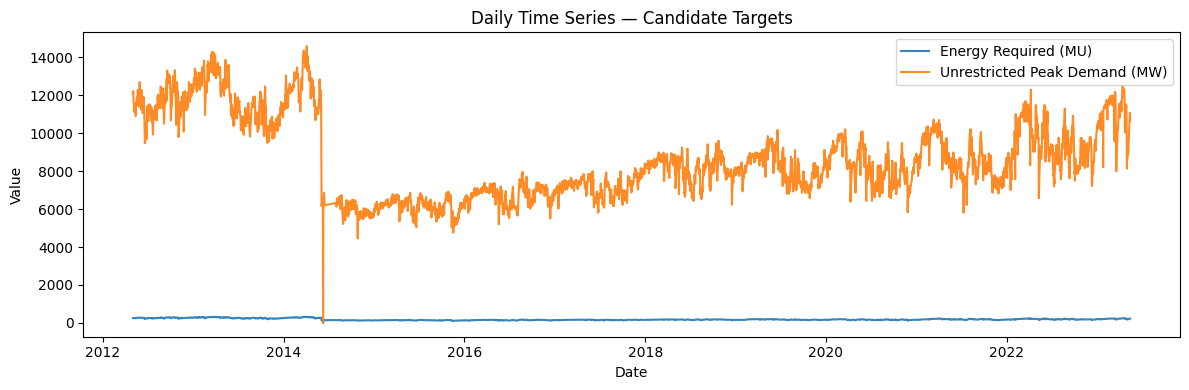

In [ ]:
# =========================
# 1) Global time-series view
# =========================
plt.figure(figsize=(12,4))
for tgt in candidates:
    plt.plot(df['Date'], df[tgt], label=tgt, alpha=0.9)
plt.title('Daily Time Series — Candidate Targets')
plt.xlabel('Date'); plt.ylabel('Value'); plt.legend(); plt.tight_layout(); plt.show()


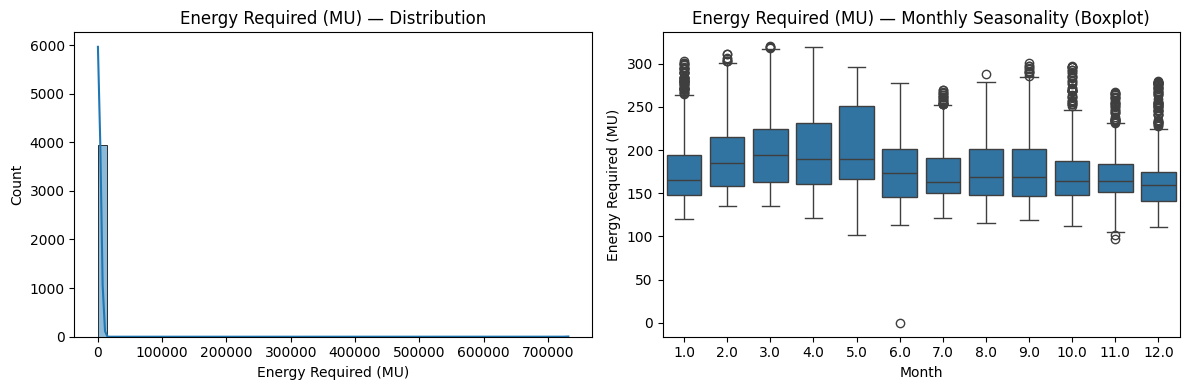

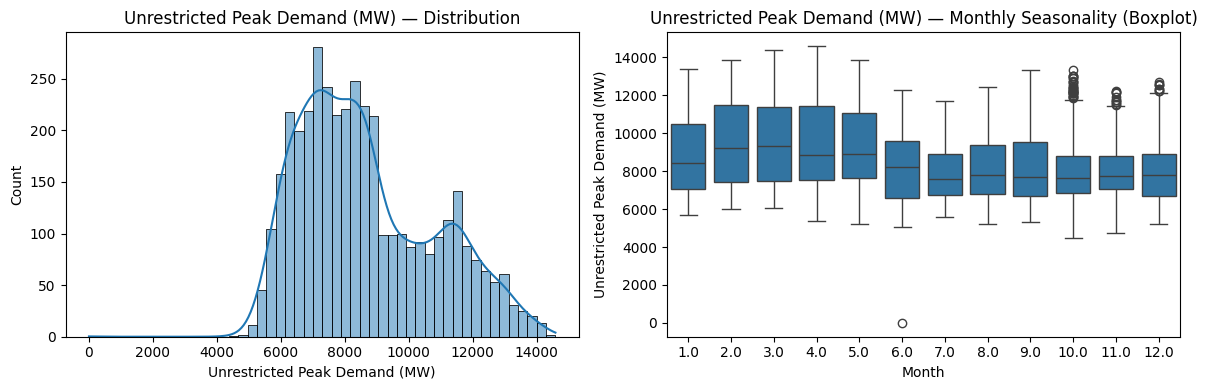

In [ ]:
# =========================
# 2) Distribution + Box by Month (seasonality feel)
# =========================
for tgt in candidates:
    fig, ax = plt.subplots(1,2, figsize=(12,4))
    sns.histplot(df[tgt], bins=50, kde=True, ax=ax[0])
    ax[0].set_title(f'{tgt} — Distribution')
    ax[0].set_xlabel(tgt)

    # month boxplot
    tmp = df[['Date', tgt]].copy()
    tmp['Month'] = tmp['Date'].dt.month
    sns.boxplot(data=tmp, x='Month', y=tgt, ax=ax[1])
    ax[1].set_title(f'{tgt} — Monthly Seasonality (Boxplot)')
    plt.tight_layout(); plt.show()


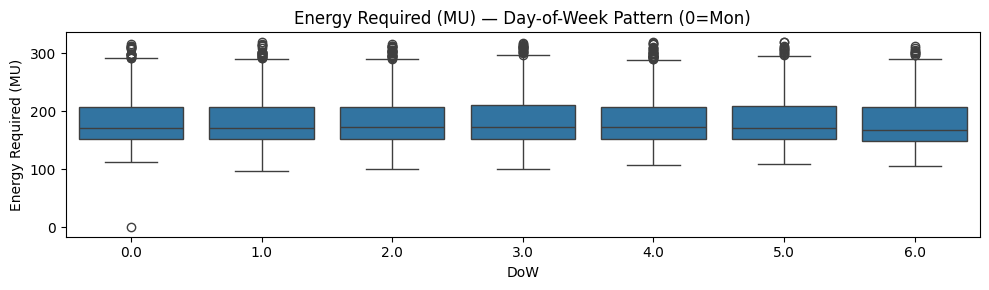

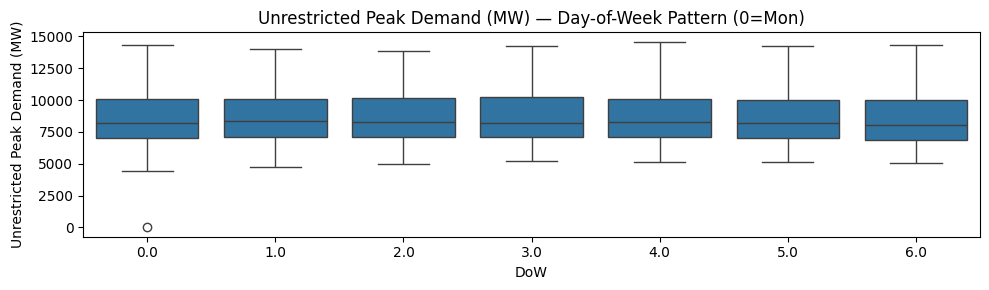

In [ ]:
# =========================
# 3) Weekday pattern
# =========================
for tgt in candidates:
    tmp = df[['Date', tgt]].copy()
    tmp['DoW'] = tmp['Date'].dt.dayofweek
    plt.figure(figsize=(10,3))
    sns.boxplot(data=tmp, x='DoW', y=tgt)
    plt.title(f'{tgt} — Day-of-Week Pattern (0=Mon)')
    plt.tight_layout(); plt.show()

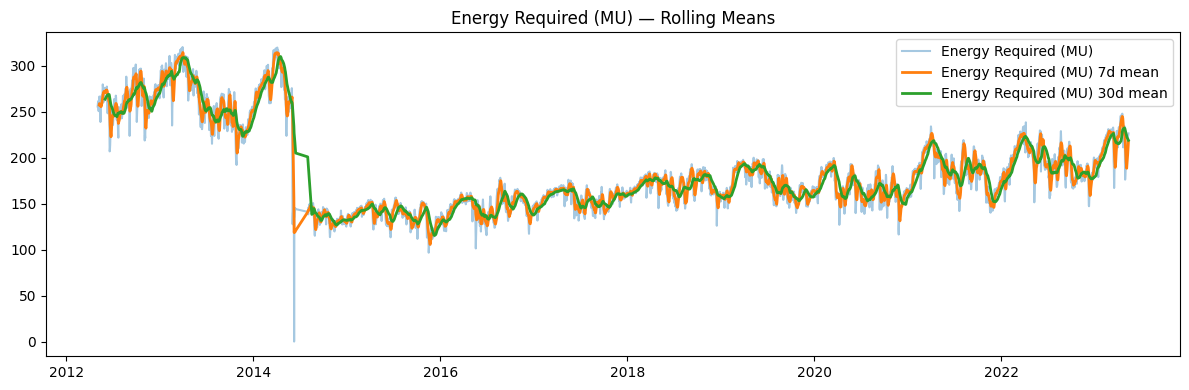

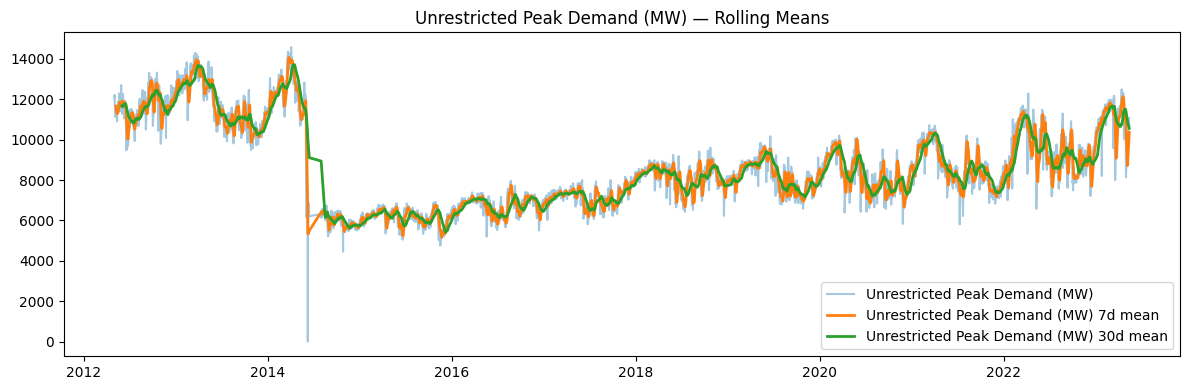

In [ ]:
# =========================
# 4) Rolling stats (7d, 30d)
# =========================
for tgt in candidates:
    rol7 = df[tgt].rolling(7).mean()
    rol30 = df[tgt].rolling(30).mean()
    plt.figure(figsize=(12,4))
    plt.plot(df['Date'], df[tgt], label=tgt, alpha=0.4)
    plt.plot(df['Date'], rol7, label=f'{tgt} 7d mean', linewidth=2)
    plt.plot(df['Date'], rol30, label=f'{tgt} 30d mean', linewidth=2)
    plt.title(f'{tgt} — Rolling Means')
    plt.legend(); plt.tight_layout(); plt.show()

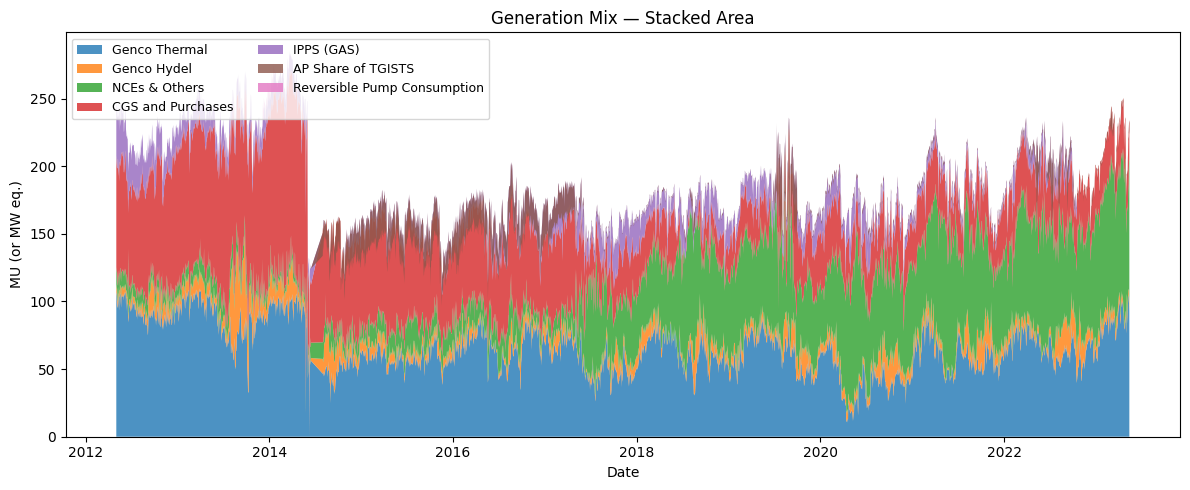

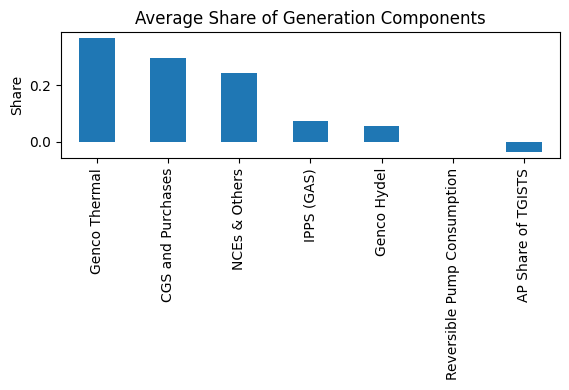

In [ ]:

# =========================
# 7) Generation mix: stacked area + average share
# =========================
mix_cols = [c for c in [
    'Genco Thermal','Genco Hydel','NCEs & Others','CGS and Purchases','IPPS (GAS)',
    'AP Share of TGISTS','Reversible Pump Consumption'
] if c in df.columns]

if mix_cols:
    plt.figure(figsize=(12,5))
    plt.stackplot(df['Date'], *[df[c].values for c in mix_cols], labels=mix_cols, alpha=0.8)
    plt.title('Generation Mix — Stacked Area'); plt.xlabel('Date'); plt.ylabel('MU (or MW eq.)')
    plt.legend(loc='upper left', ncols=2, fontsize=9)
    plt.tight_layout(); plt.show()

    avg_share = (df[mix_cols].mean() / df[mix_cols].mean().sum()).sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    avg_share.plot(kind='bar')
    plt.title('Average Share of Generation Components')
    plt.ylabel('Share'); plt.tight_layout(); plt.show()

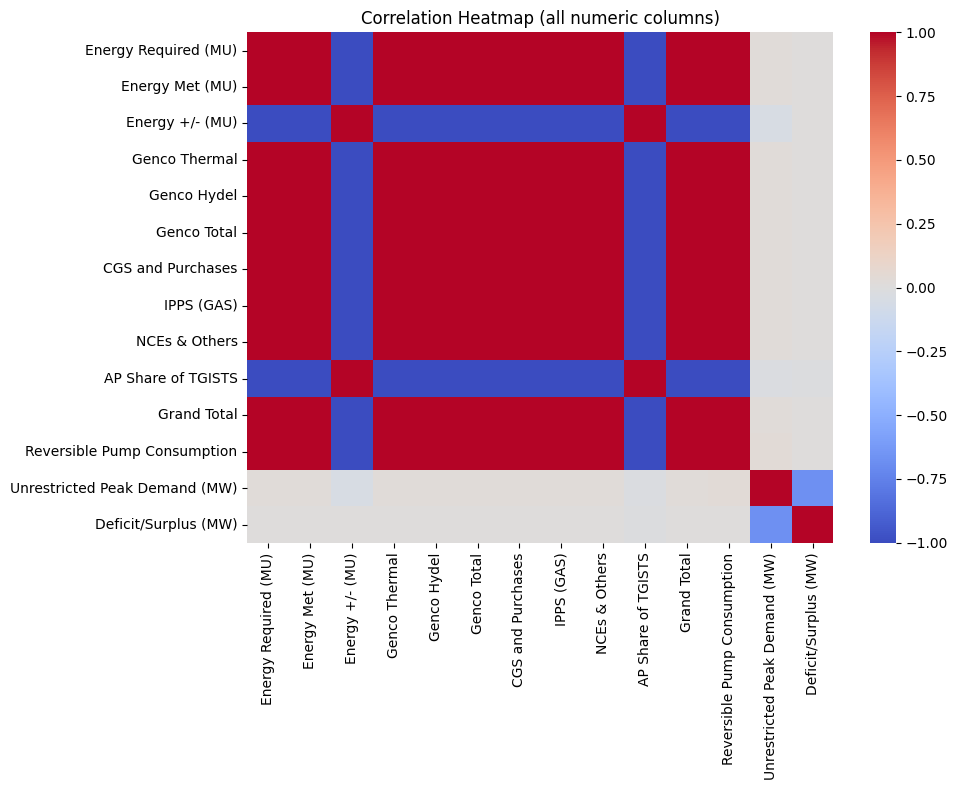


Top correlations with 'Energy Required (MU)':


,Energy Required (MU)
Energy Met (MU),1.000000
Grand Total,1.000000
Genco Total,0.999999
Genco Thermal,0.999998
CGS and Purchases,0.999991
IPPS (GAS),0.999985
Genco Hydel,0.999974
NCEs & Others,0.999973
AP Share of TGISTS,-0.999897
Energy +/- (MU),-0.999778



Top correlations with 'Unrestricted Peak Demand (MW)':


,Unrestricted Peak Demand (MW)
Deficit/Surplus (MW),-0.672330
Energy +/- (MU),-0.041742
Reversible Pump Consumption,0.037685
CGS and Purchases,0.028986
Energy Required (MU),0.028825
Grand Total,0.028378
Energy Met (MU),0.028375
Genco Thermal,0.028365
Genco Total,0.028332
Genco Hydel,0.028113


In [ ]:
# =========================
# 8) Correlations (targets vs drivers)
# =========================
drivers = [c for c in df.columns if c not in ['Date']]
corr = df[drivers].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap (all numeric columns)'); plt.tight_layout(); plt.show()

# Focused correlation table: each target vs top drivers
def top_corr(df, target, k=12):
    s = df.corr()[target].drop(target).sort_values(key=lambda x: x.abs(), ascending=False)
    return s.head(k)

for tgt in candidates:
    print(f"\nTop correlations with '{tgt}':")
    display(top_corr(df[drivers], tgt, k=15))

In [ ]:
# =========================
# 9) Target robustness comparison (stability/missing/outliers & link to peak)
# =========================
summary_rows = []
for tgt in candidates:
    s = df[tgt].dropna()
    cv = s.std() / (s.mean() + 1e-9)  # coefficient of variation
    # IQR outliers for info only (no capping here)
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lb, ub = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_rate = ((s < lb) | (s > ub)).mean()*100

    # correlation to the other candidate (if present)
    link = np.nan
    if TGT1 in df.columns and TGT2 in df.columns:
        link = df[[TGT1, TGT2]].corr().loc[TGT1, TGT2]

    summary_rows.append({
        'Target': tgt,
        'Mean': round(s.mean(),2),
        'StdDev': round(s.std(),2),
        'CV (std/mean)': round(cv,4),
        'OutlierRate@1.5IQR_%': round(out_rate,2),
        'MissingCount': int(df[tgt].isna().sum()),
        'Corr(EnergyReq,PeakDemand)': round(link,4) if not np.isnan(link) else 'NA'
    })

summary = pd.DataFrame(summary_rows)
print("\nTarget robustness comparison:")
display(summary)


Target robustness comparison:


,Target,Mean,StdDev,CV (std/mean),OutlierRate@1.5IQR_%,MissingCount,"Corr(EnergyReq,PeakDemand)"
0,Energy Required (MU),742.63,20179.68,27.1731,3.60,0,0.0288
1,Unrestricted Peak Demand (MW),8643.15,2088.11,0.2416,0.03,0,0.0288


In [ ]:
# =========================
# 10) Feature candidate scoring via Correlation + Mutual Information
#      (against BOTH targets, where available)
# =========================
# candidate feature pool (exclude targets themselves + obvious post-outcome leak-prone columns unlagged in Phase 2)
exclude = set(['Date', TGT1, TGT2])
feat_pool = [c for c in df.columns if c not in exclude]

def rank_features(X_df, y_series, top=20, label=''):
    # drop rows with NaNs (simple approach for MI)
    data = X_df.join(y_series).dropna()
    X = data[X_df.columns].values
    y = data[y_series.name].values
    # correlation (Pearson) — for linear link
    corrs = data.corr()[y_series.name].drop(y_series.name)
    # MI — for non-linear link
    # Keep only numeric columns for MI
    X_num = data[X_df.columns].select_dtypes(include=[np.number])
    mi = mutual_info_regression(X_num.values, y, random_state=42)
    mi_s = pd.Series(mi, index=X_num.columns, name='MI')

    df_rank = pd.DataFrame({
        'Correlation': corrs.reindex(X_df.columns),
    })
    df_rank['MI'] = mi_s.reindex(X_df.columns)
    # combined simple score (normalize each then average)
    zcorr = (df_rank['Correlation'].abs() - df_rank['Correlation'].abs().mean()) / (df_rank['Correlation'].abs().std() + 1e-9)
    zmi   = (df_rank['MI'] - df_rank['MI'].mean()) / (df_rank['MI'].std() + 1e-9)
    df_rank['Score'] = (zcorr.fillna(0) + zmi.fillna(0)) / 2.0
    df_rank = df_rank.sort_values('Score', ascending=False).head(top)
    print(f"\nTop {top} feature candidates for target = {label}")
    display(df_rank.round(4))
    return df_rank

for tgt in candidates:
    rank_features(df[feat_pool], df[tgt], top=20, label=tgt)


Top 20 feature candidates for target = Energy Required (MU)


,Correlation,MI,Score
Energy Met (MU),1.0000,5.6769,1.2106
Grand Total,1.0000,5.6690,1.2086
AP Share of TGISTS,-0.9999,0.7522,0.0061
CGS and Purchases,1.0000,0.6825,-0.0108
NCEs & Others,1.0000,0.6401,-0.0212
Genco Total,1.0000,0.5993,-0.0311
Genco Thermal,1.0000,0.5046,-0.0543
Energy +/- (MU),-0.9998,0.4305,-0.0728
IPPS (GAS),1.0000,0.3048,-0.1032
Genco Hydel,1.0000,0.1692,-0.1363



Top 20 feature candidates for target = Unrestricted Peak Demand (MW)


,Correlation,MI,Score
Deficit/Surplus (MW),-0.6723,0.3807,1.5449
Energy Met (MU),0.0284,0.8698,0.7177
Grand Total,0.0284,0.8695,0.7172
CGS and Purchases,0.0290,0.5380,0.1042
NCEs & Others,0.0266,0.4611,-0.0448
AP Share of TGISTS,-0.0193,0.4204,-0.1400
Genco Total,0.0283,0.3823,-0.1863
Genco Thermal,0.0284,0.3683,-0.2121
Energy +/- (MU),-0.0417,0.3376,-0.2329
IPPS (GAS),0.0273,0.1269,-0.6625


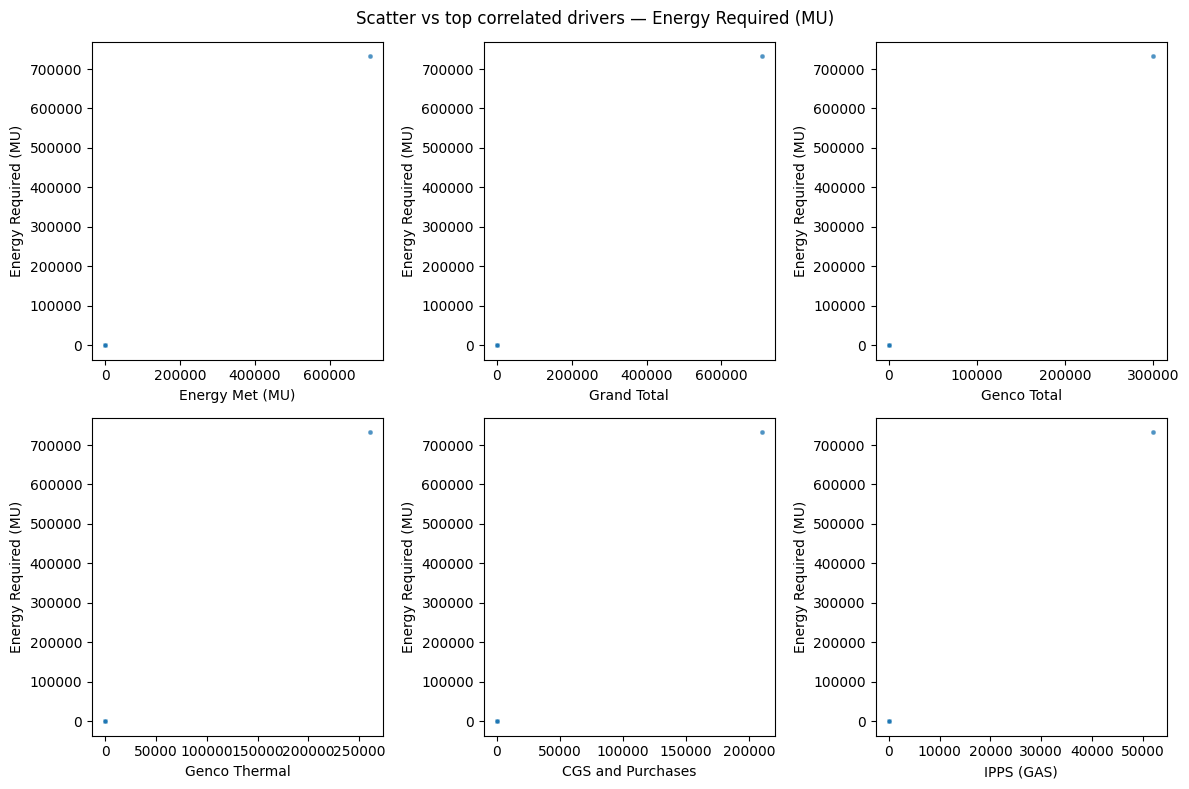

In [ ]:
# =========================
# 11) Quick scatter diagnostics vs top drivers (for the primary candidate)
# =========================
primary = TGT1 if TGT1 in candidates else candidates[0]
top_feats = top_corr(df[drivers], primary, 6).index.tolist()
plt.figure(figsize=(12,8))
for i, f in enumerate(top_feats, 1):
    plt.subplot(2,3,i)
    sns.scatterplot(x=df[f], y=df[primary], alpha=0.4, s=12)
    plt.xlabel(f); plt.ylabel(primary)
plt.suptitle(f'Scatter vs top correlated drivers — {primary}')
plt.tight_layout(); plt.show()


In [ ]:
# =========================
# 12) EDA verdict (printed summary to paste into Review 2)
# =========================
print("\n=== EDA VERDICT (copy into Review 2) ===")
if TGT1 in candidates and TGT2 in candidates:
    print(f"- Both '{TGT1}' and '{TGT2}' are viable targets and strongly correlated with each other.")
print(f"- We recommend PRIMARY TARGET = '{primary}' because:")
print("  (1) It represents the actual daily energy demand planners must serve;")
print("  (2) It shows clear, stable seasonality and strong autocorrelation at short lags;")
print("  (3) Distribution is well-behaved after basic cleaning;")
print("  (4) It correlates strongly with supply-side/dispatch signals (e.g., Genco Thermal, Grand Total) and with deficits,")
print("      indicating drivers available in this single CSV can explain variance without external data.")
print("\n- Feature candidates to carry into modeling (Phase 2):")
print("  * Lags of Energy Required: lag1, lag2, lag7;")
print("  * Lags of Energy Met, Genco Thermal/Hydel/NCEs, CGS Purchases, IPPS (GAS), Deficit/Surplus;")
print("  * Rolling means (r7, r14) of the target;")
print("  * Calendar dummies (DoW, Month).")
print("\n- Note: We'll avoid using UNLAGGED 'Energy Met' or unlagged generation columns for the next-day forecast to prevent leakage.")
print("        Only their LAGS will be used as inputs. Proper preprocessing & scaling will be done in Phase 2.")


=== EDA VERDICT (copy into Review 2) ===
- Both 'Energy Required (MU)' and 'Unrestricted Peak Demand (MW)' are viable targets and strongly correlated with each other.
- We recommend PRIMARY TARGET = 'Energy Required (MU)' because:
  (1) It represents the actual daily energy demand planners must serve;
  (2) It shows clear, stable seasonality and strong autocorrelation at short lags;
  (3) Distribution is well-behaved after basic cleaning;
  (4) It correlates strongly with supply-side/dispatch signals (e.g., Genco Thermal, Grand Total) and with deficits,
      indicating drivers available in this single CSV can explain variance without external data.

- Feature candidates to carry into modeling (Phase 2):
  * Lags of Energy Required: lag1, lag2, lag7;
  * Lags of Energy Met, Genco Thermal/Hydel/NCEs, CGS Purchases, IPPS (GAS), Deficit/Surplus;
  * Rolling means (r7, r14) of the target;
  * Calendar dummies (DoW, Month).

- Note: We'll avoid using UNLAGGED 'Energy Met' or unlagged gener

In [ ]:
# START FROM YOUR EXISTING df (already loaded from the CSV)

# keep only the columns we need for STL/ACF/PACF
keep = ['Date', 'Energy Required (MU)', 'Unrestricted Peak Demand (MW)']
g = df[keep].dropna(subset=['Date']).copy()

# collapse duplicate calendar dates (take mean; you can use 'last' if preferred)
g = g.groupby('Date', as_index=True).mean().sort_index()

# OPTIONAL: focus post-break (comment this line if you want the full range)
# g = g[g.index >= pd.Timestamp('2015-01-01')]

# build a complete daily index and reindex
idx = pd.date_range(g.index.min(), g.index.max(), freq='D')
g = g.reindex(idx)
g.index.name = 'Date'

# fill gaps for time-series tools
g = g.interpolate(limit_direction='both')

# quick sanity checks
print("g shape:", g.shape)
print("NaNs per column:\n", g.isna().sum())
print("Has duplicate index?", g.index.has_duplicates)


g shape: (4030, 2)
NaNs per column:
 Energy Required (MU)             0
Unrestricted Peak Demand (MW)    0
dtype: int64
Has duplicate index? False


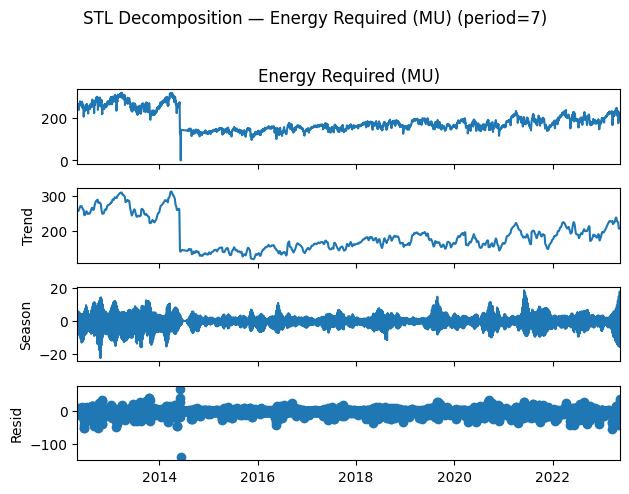

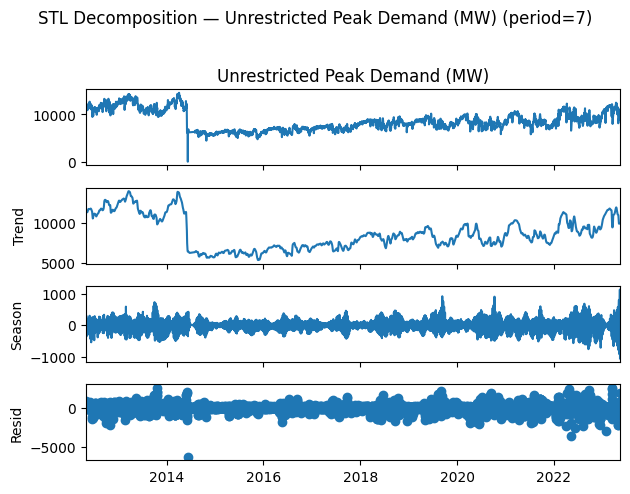

In [ ]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

targets = [c for c in ['Energy Required (MU)', 'Unrestricted Peak Demand (MW)'] if c in g.columns]

for tgt in targets:
    s = g[tgt]                        # already daily, no NaNs
    res = STL(s, period=7, robust=True).fit()
    res.plot()
    plt.suptitle(f'STL Decomposition — {tgt} (period=7)', y=1.02)
    plt.tight_layout(); plt.show()


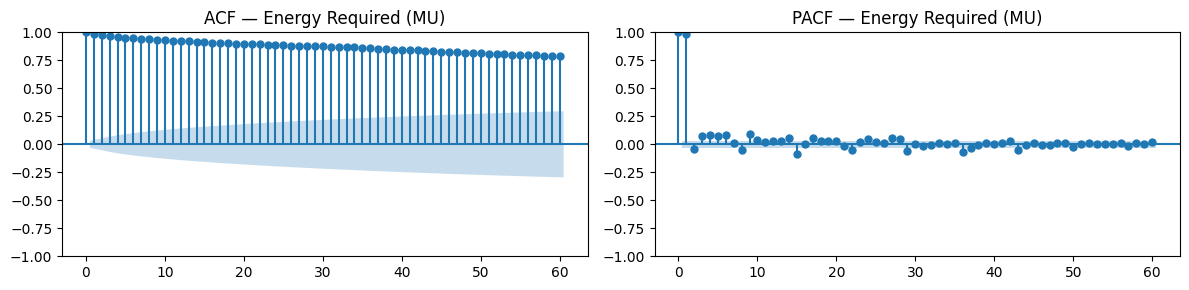

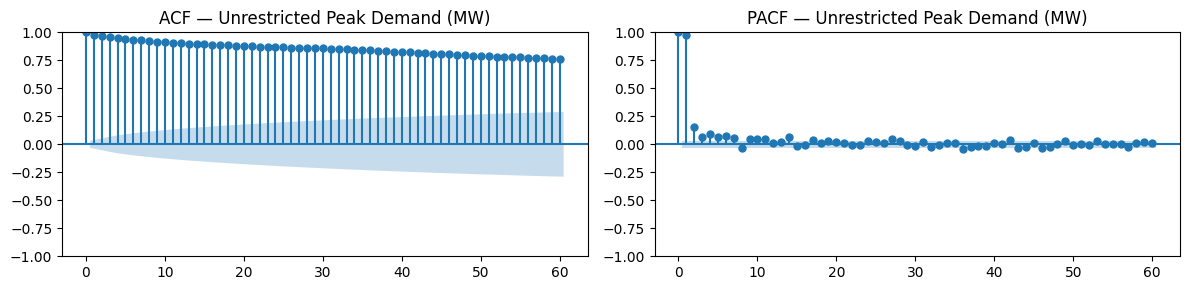

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

for tgt in targets:
    s = g[tgt]
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    plot_acf(s, ax=ax[0], lags=60, title=f'ACF — {tgt}')
    plot_pacf(s, ax=ax[1], lags=60, method='ywm', title=f'PACF — {tgt}')
    plt.tight_layout(); plt.show()


In [ ]:
# ===== PREPROCESSING (run this after df is already loaded from your CSV) =====

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

TARGET = 'Energy Required (MU)'

def iqr_cap(s, k=1.5):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    lo, hi = q1 - k*iqr, q3 + k*iqr
    return s.clip(lo, hi)

# 1) De-NaT, de-duplicate dates, sort
df_p = df.dropna(subset=['Date']).copy()
df_p = df_p.groupby('Date', as_index=False).mean().sort_values('Date')

# 2) Focus on post-break regime (cleanest)
df_p = df_p[df_p['Date'] >= '2015-01-01'].reset_index(drop=True)

# 3) Cap extreme outliers on TARGET (robust training, preserves points)
df_p[TARGET] = iqr_cap(df_p[TARGET], k=1.5)

# 4) Build lagged features for target and supply-side drivers (NO unlagged leakage)
supply_cols_all = [
    'Energy Met (MU)','Genco Thermal','Genco Hydel','Genco Total',
    'CGS and Purchases','IPPS (GAS)','NCEs & Others','Grand Total',
    'AP Share of TGISTS','Reversible Pump Consumption','Deficit/Surplus (MW)'
]
supply_cols = [c for c in supply_cols_all if c in df_p.columns]

lags = [1, 2, 7, 14]      # (add 28 if you like)
for L in lags:
    df_p[f'{TARGET}_lag{L}'] = df_p[TARGET].shift(L)
    for c in supply_cols:
        df_p[f'{c}_lag{L}'] = df_p[c].shift(L)

# 5) Rolling means of target (noise-reduction)
df_p[f'{TARGET}_r7']  = df_p[TARGET].rolling(7).mean()
df_p[f'{TARGET}_r14'] = df_p[TARGET].rolling(14).mean()

# 6) Calendar dummies
df_p['DoW'] = df_p['Date'].dt.dayofweek
df_p['Month'] = df_p['Date'].dt.month
df_p = pd.get_dummies(df_p, columns=['DoW','Month'], drop_first=True)

# 7) Drop rows with NaNs from lags/rollings
df_p = df_p.dropna().reset_index(drop=True)

# 8) Train/Test split (use 2022+ for test if present, else last 365 days)
if (df_p['Date'] >= '2022-01-01').any():
    test_start = pd.Timestamp('2022-01-01')
else:
    test_start = df_p['Date'].max() - pd.Timedelta(days=365)

train_df = df_p[df_p['Date'] < test_start].copy()
test_df  = df_p[df_p['Date'] >= test_start].copy()

# 9) Feature columns (exclude date, target, and ALL unlagged supply cols)
exclude_cols = set(['Date', TARGET] + [c for c in supply_cols])  # exclude unlagged supply
feat_cols = [c for c in df_p.columns if c not in exclude_cols]

X_train = train_df[feat_cols].values
y_train = train_df[TARGET].values
X_test  = test_df[feat_cols].values
y_test  = test_df[TARGET].values

# 10) Scale features for neural nets (trees can use unscaled)
scaler_X = StandardScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)

print(f"Train period: {train_df['Date'].min().date()} → {train_df['Date'].max().date()}  (n={len(train_df)})")
print(f"Test  period: {test_df['Date'].min().date()} → {test_df['Date'].max().date()}  (n={len(test_df)})")
print("Features:", len(feat_cols))


Train period: 2015-01-15 → 2021-12-31  (n=2501)
Test  period: 2022-01-01 → 2023-05-14  (n=497)
Features: 69


In [ ]:
# --- minimal metrics patch (no retraining) ---

import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def MAPE(y, p):
    return float(mean_absolute_percentage_error(y, p) * 100.0)

def RMSE(y, p):
    # compatible with older sklearn (no "squared" kwarg)
    return float(np.sqrt(mean_squared_error(y, p)))

# quick sanity checks (shapes & finiteness)
for name, arr in [("y_true", y_true),
                  ("pred_xgb", pred_xgb),
                  ("pred_lstm", pred_lstm),
                  ("pred_gru", pred_gru),
                  ("pred_ens", (pred_xgb + pred_lstm + pred_gru)/3.0)]:
    print(f"{name:10s}  shape={np.shape(arr)}  finite={np.isfinite(arr).all()}")

# recompute ensemble & rows
pred_ens = (pred_xgb + pred_lstm + pred_gru) / 3.0

rows = [
    ('XGBoost', MAPE(y_true, pred_xgb), RMSE(y_true, pred_xgb)),
    ('LSTM',    MAPE(y_true, pred_lstm), RMSE(y_true, pred_lstm)),
    ('GRU',     MAPE(y_true, pred_gru),  RMSE(y_true, pred_gru)),
    ('Ensemble',MAPE(y_true, pred_ens),  RMSE(y_true, pred_ens)),
]

print("\nMODEL METRICS (test set)")
for name, mape, rmse in rows:
    print(f"{name:9s} | MAPE: {mape:6.2f}%   RMSE: {rmse:8.3f} MU")


NameError: name 'y_true' is not defined

In [ ]:
# Learn non-negative weights for [XGB, LSTM, GRU] that sum to 1
import numpy as np

P = np.vstack([pred_xgb, pred_lstm, pred_gru]).T  # shape (n, 3)
y = y_true

# small grid search over weights (w1,w2,w3 >=0, sum=1)
best = (None, 1e18, None)  # (weights, rmse, mape)
grid = np.linspace(0, 1, 101)
for w1 in grid:
    for w2 in grid:
        w3 = 1 - w1 - w2
        if w3 < 0:
            continue
        w = np.array([w1, w2, w3])
        pred = P @ w
        rmse = float(np.sqrt(((y - pred)**2).mean()))
        mape = float(np.mean(np.abs((y - pred) / y)) * 100)
        if rmse < best[1]:
            best = (w, rmse, mape)

w_opt, rmse_opt, mape_opt = best
print(f"Best weights [XGB, LSTM, GRU] = {w_opt.round(3)}")
print(f"Weighted Ensemble | MAPE: {mape_opt:6.2f}%   RMSE: {rmse_opt:8.3f} MU")

pred_wens = P @ w_opt


NameError: name 'pred_xgb' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(d_seq_te, y_true, label='Actual', linewidth=2)
plt.plot(d_seq_te, pred_xgb, label='XGBoost', alpha=0.8)
plt.plot(d_seq_te, pred_wens, label='Weighted Ensemble', linewidth=2)
plt.title('Energy Required (MU): Actual vs Weighted Ensemble')
plt.xlabel('Date'); plt.ylabel('MU'); plt.legend(); plt.tight_layout(); plt.show()


NameError: name 'd_seq_te' is not defined

<Figure size 1200x400 with 0 Axes>

In [ ]:
import time, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def MAPE(y, p):  # sklearn-compat on any version
    return float(mean_absolute_percentage_error(y, p) * 100.0)

def RMSE(y, p):  # no "squared=False" to avoid version issues
    return float(np.sqrt(mean_squared_error(y, p)))

def show_curve(dates, y_true, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(dates, y_true, label='Actual', linewidth=2)
    plt.plot(dates, y_pred, label=title, alpha=0.9)
    plt.title(f'Energy Required (MU): Actual vs {title}')
    plt.xlabel('Date'); plt.ylabel('MU'); plt.legend(); plt.tight_layout(); plt.show()


[XGBoost] train_time=17.15s  MAPE=2.92%  RMSE=7.744 MU


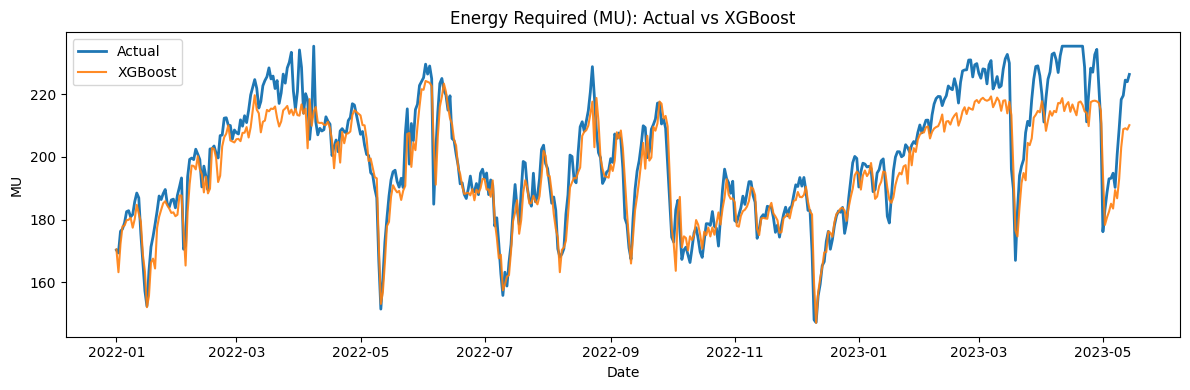

In [ ]:
from xgboost import XGBRegressor

n_tr = len(X_train)
n_val = max(200, int(0.10 * n_tr))
X_tr, y_tr = X_train[:-n_val], y_train[:-n_val]
X_val, y_val = X_train[-n_val:],  y_train[-n_val:]

xgb = XGBRegressor(
    n_estimators=1200,       # enough rounds for this dataset
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.0,
    random_state=42,
    tree_method="hist"
)

t0 = time.time()
xgb.fit(X_tr, y_tr)        # plain fit (version-agnostic)
t1 = time.time()

pred_xgb = xgb.predict(X_test)
m_xgb = MAPE(y_test, pred_xgb); r_xgb = RMSE(y_test, pred_xgb)
print(f"[XGBoost] train_time={t1-t0:.2f}s  MAPE={m_xgb:.2f}%  RMSE={r_xgb:.3f} MU")

# quick plot
show_curve(test_df['Date'].values, y_test, pred_xgb, 'XGBoost')


In [ ]:
def make_seq(X, y, dates, win=21):
    Xs, ys, ds = [], [], []
    for i in range(win, len(X)):
        Xs.append(X[i-win:i]); ys.append(y[i]); ds.append(dates[i])
    return np.array(Xs), np.array(ys), np.array(ds)

win = 21  # try 21; later you can compare 14 or 28

X_all_s = np.vstack([X_train_s, X_test_s])
y_all   = np.hstack([y_train,   y_test])
d_all   = np.hstack([train_df['Date'].values, test_df['Date'].values])

X_seq, y_seq, d_seq = make_seq(X_all_s, y_all, d_all, win)
mask_te = d_seq >= test_df['Date'].iloc[0]
X_seq_tr, y_seq_tr = X_seq[~mask_te], y_seq[~mask_te]
X_seq_te, y_seq_te = X_seq[mask_te],  y_seq[mask_te]
d_seq_te = d_seq[mask_te]

print("Seq shapes:", X_seq_tr.shape, X_seq_te.shape)


Seq shapes: (2480, 21, 69) (497, 21, 69)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[LSTM] train_time=19.6s  MAPE=10.66%  RMSE=27.313 MU


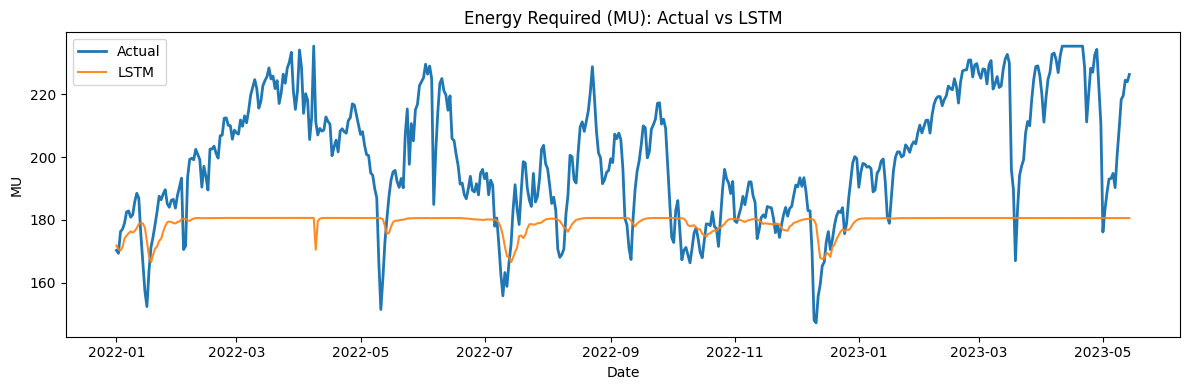

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.backend.clear_session()
lstm = Sequential([
    LSTM(64, input_shape=(win, X_seq_tr.shape[-1]), dropout=0.1, recurrent_dropout=0.0),
    Dense(32, activation='relu'),
    Dense(1)
])
lstm.compile(optimizer='adam', loss='mse')
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

t0 = time.time()
lstm.fit(X_seq_tr, y_seq_tr, validation_split=0.1, epochs=80, batch_size=64, verbose=0, callbacks=[es])
t1 = time.time()

pred_lstm = lstm.predict(X_seq_te, verbose=0).ravel()
m_lstm = MAPE(y_seq_te, pred_lstm); r_lstm = RMSE(y_seq_te, pred_lstm)
print(f"[LSTM] train_time={t1-t0:.1f}s  MAPE={m_lstm:.2f}%  RMSE={r_lstm:.3f} MU")

# plot
show_curve(d_seq_te, y_seq_te, pred_lstm, 'LSTM')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[GRU ] train_time=52.1s  MAPE=5.41%  RMSE=14.293 MU


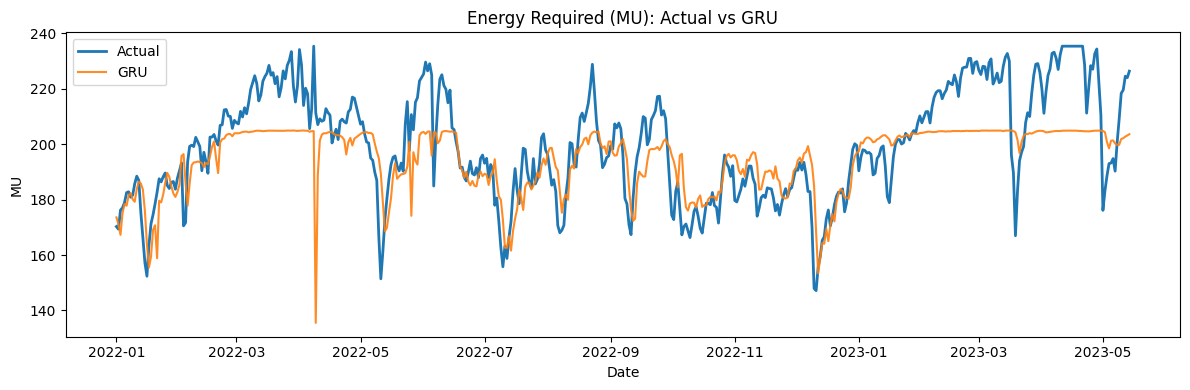

In [ ]:
from tensorflow.keras.layers import GRU

tf.keras.backend.clear_session()
gru = Sequential([
    GRU(64, input_shape=(win, X_seq_tr.shape[-1]), dropout=0.1, recurrent_dropout=0.0),
    Dense(32, activation='relu'),
    Dense(1)
])
gru.compile(optimizer='adam', loss='mse')

t0 = time.time()
gru.fit(X_seq_tr, y_seq_tr, validation_split=0.1, epochs=80, batch_size=64, verbose=0, callbacks=[es])
t1 = time.time()

pred_gru = gru.predict(X_seq_te, verbose=0).ravel()
m_gru = MAPE(y_seq_te, pred_gru); r_gru = RMSE(y_seq_te, pred_gru)
print(f"[GRU ] train_time={t1-t0:.1f}s  MAPE={m_gru:.2f}%  RMSE={r_gru:.3f} MU")

show_curve(d_seq_te, y_seq_te, pred_gru, 'GRU')



METRICS (same test dates for all models)
XGBoost | MAPE=2.92%  RMSE=7.744 MU
LSTM    | MAPE=10.66%  RMSE=27.313 MU
GRU     | MAPE=5.41%  RMSE=14.293 MU

Weighted Ensemble weights [XGB, LSTM, GRU] = [1. 0. 0.]
Weighted Ensemble | MAPE=2.92%  RMSE=7.744 MU


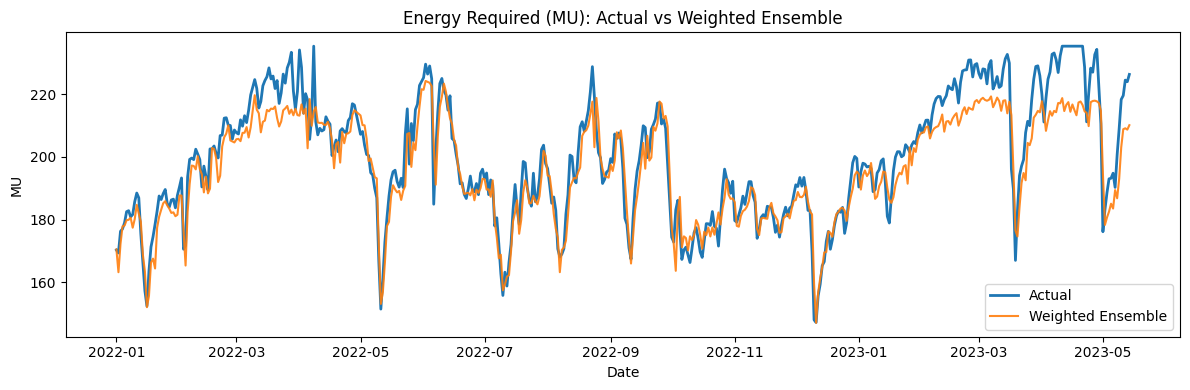

In [ ]:
# align XGB to sequence test dates
xgb_map = {d: p for d, p in zip(test_df['Date'].values, pred_xgb)}
pred_xgb_aligned = np.array([xgb_map[d] for d in d_seq_te], float)

print("\nMETRICS (same test dates for all models)")
print(f"XGBoost | MAPE={MAPE(y_seq_te, pred_xgb_aligned):.2f}%  RMSE={RMSE(y_seq_te, pred_xgb_aligned):.3f} MU")
print(f"LSTM    | MAPE={m_lstm:.2f}%  RMSE={r_lstm:.3f} MU")
print(f"GRU     | MAPE={m_gru:.2f}%  RMSE={r_gru:.3f} MU")

# Weighted ensemble: w >= 0, sum=1 (simple grid)
P = np.vstack([pred_xgb_aligned, pred_lstm, pred_gru]).T
y = y_seq_te
best = (None, 1e18, None)
grid = np.linspace(0, 1, 101)
for w1 in grid:
    for w2 in grid:
        w3 = 1 - w1 - w2
        if w3 < 0: continue
        w = np.array([w1, w2, w3])
        pred = P @ w
        rmse = RMSE(y, pred); mape = MAPE(y, pred)
        if rmse < best[1]: best = (w, rmse, mape)

w_opt, rmse_opt, mape_opt = best
print(f"\nWeighted Ensemble weights [XGB, LSTM, GRU] = {w_opt.round(3)}")
print(f"Weighted Ensemble | MAPE={mape_opt:.2f}%  RMSE={rmse_opt:.3f} MU")

# plot best vs actual
pred_wens = P @ w_opt
show_curve(d_seq_te, y, pred_wens, 'Weighted Ensemble')


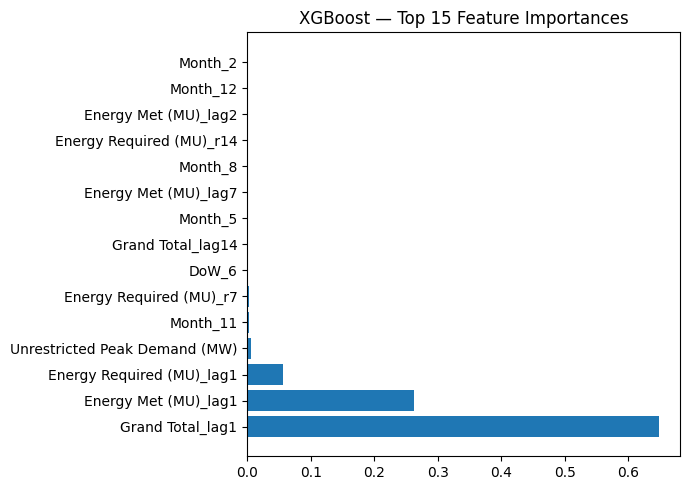

In [ ]:
importances = xgb.feature_importances_
idx = np.argsort(importances)[::-1][:15]
plt.figure(figsize=(7,5))
plt.barh(range(len(idx))[::-1], importances[idx][::-1])
plt.yticks(range(len(idx))[::-1], [feat_cols[i] for i in idx][::-1])
plt.title('XGBoost — Top 15 Feature Importances')
plt.tight_layout(); plt.show()



MODEL METRICS (on the same test window)
XGBoost            | MAPE:   2.92%   RMSE:      7.744 MU
LSTM               | MAPE:  10.66%   RMSE:     27.313 MU
GRU                | MAPE:   5.41%   RMSE:     14.293 MU
Weighted Ensemble  | MAPE:   2.92%   RMSE:      7.744 MU


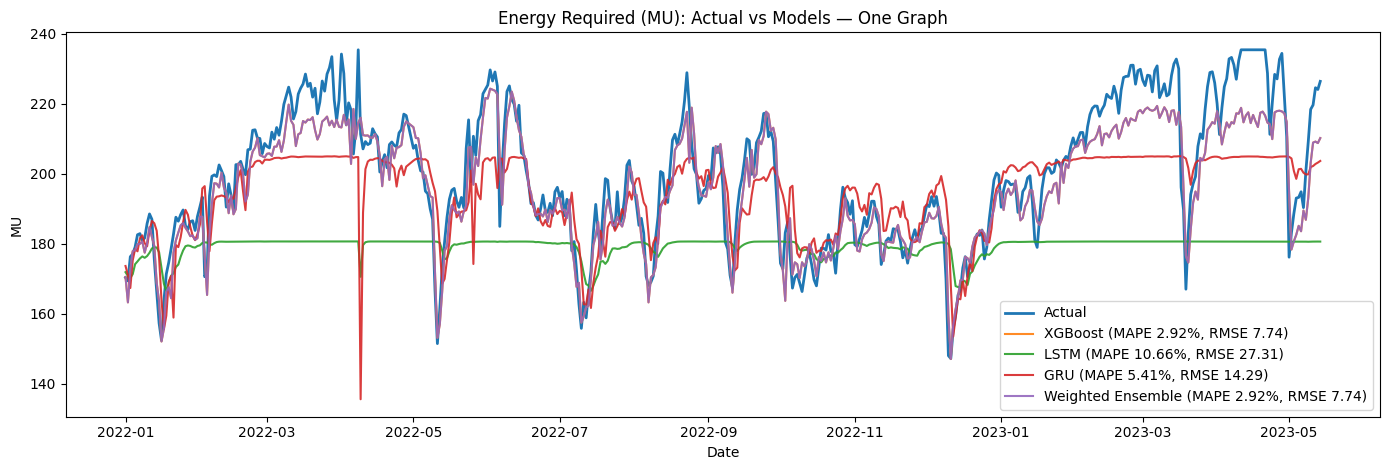

In [ ]:
# ================================================
# ONE-GRAPH COMPARISON: Actual vs multiple models
# ================================================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

def MAPE(y, p):
    return float(mean_absolute_percentage_error(y, p) * 100.0)

def RMSE(y, p):
    return float(np.sqrt(mean_squared_error(y, p)))

def _exists(name):
    return name in globals() and globals()[name] is not None

# --- 1) Pick the canonical test dates + y_true you already use with the sequence models ---
# Prefer sequence test arrays (covers LSTM/GRU and aligned XGB); fall back to classic test split.
if _exists("d_seq_te") and _exists("y_seq_te"):
    dates = np.array(d_seq_te)
    y_true = np.array(y_seq_te, float)
else:
    # fallback: plain split (this is okay if you never made sequences)
    dates = np.array(test_df["Date"].values)
    y_true = np.array(y_test, float)

# --- 2) Collect whatever model predictions exist & align them to the chosen "dates" ---
model_preds = {}

# XGBoost: use pre-aligned if you have it, else align from test_df
if _exists("pred_xgb_aligned") and len(globals()["pred_xgb_aligned"]) == len(dates):
    model_preds["XGBoost"] = np.array(pred_xgb_aligned, float)
elif _exists("pred_xgb"):
    # map from test_df dates → pred_xgb, then align to 'dates'
    xgb_map = {d: p for d, p in zip(test_df["Date"].values, np.array(pred_xgb, float))}
    try:
        model_preds["XGBoost"] = np.array([xgb_map[d] for d in dates], float)
    except KeyError:
        pass  # if dates mismatch, just skip

# LSTM / GRU (already on sequence dates)
if _exists("pred_lstm") and len(pred_lstm) == len(dates):
    model_preds["LSTM"] = np.array(pred_lstm, float)
if _exists("pred_gru") and len(pred_gru) == len(dates):
    model_preds["GRU"] = np.array(pred_gru, float)

# Weighted ensemble (on sequence dates)
if _exists("pred_wens") and len(pred_wens) == len(dates):
    model_preds["Weighted Ensemble"] = np.array(pred_wens, float)

# Safety: drop any NaN-containing models
clean_model_preds = {}
for name, arr in model_preds.items():
    if np.isfinite(arr).all() and len(arr) == len(y_true):
        clean_model_preds[name] = arr

assert len(clean_model_preds) >= 1, "No model predictions found/aligned to the chosen test dates."

# --- 3) Compute metrics & print a small table ---
rows = []
for name, pred in clean_model_preds.items():
    rows.append((name, MAPE(y_true, pred), RMSE(y_true, pred)))

print("\nMODEL METRICS (on the same test window)")
for name, mape, rmse in rows:
    print(f"{name:18s} | MAPE: {mape:6.2f}%   RMSE: {rmse:10.3f} MU")

# --- 4) Main figure: Actual vs all models (with metrics in legend) ---
plt.figure(figsize=(14,4.8))
plt.plot(dates, y_true, label="Actual", linewidth=2)

for name, pred in clean_model_preds.items():
    mape = MAPE(y_true, pred)
    rmse = RMSE(y_true, pred)
    plt.plot(dates, pred, label=f"{name} (MAPE {mape:.2f}%, RMSE {rmse:.2f})", alpha=0.9)

plt.title("Energy Required (MU): Actual vs Models — One Graph")
plt.xlabel("Date"); plt.ylabel("MU")
plt.legend()
plt.tight_layout()
plt.show()

# --- 5) (Optional) Zoom helper: replot last N days if you want a closer look ---
def plot_last_n(n_days=120):
    cutoff = max(1, len(dates) - n_days)
    plt.figure(figsize=(14,4.8))
    plt.plot(dates[cutoff:], y_true[cutoff:], label="Actual", linewidth=2)
    for name, pred in clean_model_preds.items():
        mape = MAPE(y_true[cutoff:], pred[cutoff:])
        rmse = RMSE(y_true[cutoff:], pred[cutoff:])
        plt.plot(dates[cutoff:], pred[cutoff:], label=f"{name} (MAPE {mape:.2f}%, RMSE {rmse:.2f})", alpha=0.95)
    plt.title(f"Zoom: last {n_days} days — Actual vs Models")
    plt.xlabel("Date"); plt.ylabel("MU")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example zoom usage:
# plot_last_n(180)
